# Lab 3.4: Gene Set Enrichment Analysis and Co-Expression Clustering 

## Name:Katherine Yun (myun7)

### Due: Wednesday, May 1st , 2019 at 11:59 PM

**Logistics and Lab Submission**

See the [course website](https://courses.engr.illinois.edu/ece365/sp2019/labsHernaez.html). Submit your completed Jupyter notebook (name it netid.ipynb) on Compass. If your code depends on any files not provided for the lab, then also upload those (in netid.zip file). Be sure to fill in your name + netid at the top of the lab. **Do not submit the data sets!**

**What You Will Need To Know For This Lab**

This lab covers the topics:
- Linear Model Formulation to Differential Expression
- Gene Set Enrichment Tests
- Clustering Genes by Co-Expression (*Bonus*)

There are some problems that have short answer questions. <b>Do not write an essay -- a few (1-2) complete sentences will suffice.</b>

### Package installations
The following packages will need to be installed for this lab. These should install only the first time you run this cell and not in future runs. If the packages have never been installed before, this cell will take many minutes to run, be patient.

In [1]:
# install missing packages from CRAN
#remove.packages("htmlwidgets")
options(repos=structure(c(CRAN="https://cran.r-project.org")))
new_cran_packages <- c("devtools", "tidyverse", "htmlwidgets")
existing_packages <- installed.packages()[,"Package"]
missing_packages <- new_cran_packages[!(new_cran_packages %in% existing_packages)]
if(length(missing_packages)){
    install.packages(missing_packages)
}

# install missing packages from Bioconductor
new_bioc_packages <- c("biomaRt", "org.Hs.eg.db", "topGO", "WGCNA", "Rgraphviz")
existing_packages <- installed.packages()[,"Package"]
missing_packages <- new_bioc_packages[!(new_bioc_packages %in% existing_packages)]
if(length(missing_packages)){
    source("http://www.bioconductor.org/biocLite.R")
    biocLite(missing_packages)
}

### Problem 1: Linear Models for Differential Expression (30 points)
In this problem, we will attempt to recreate part of Bio Lectures 6 and 7 and show how fitted linear regression models can be used to find *differentially expressed* (DE) genes. Differentially expressed genes are important to researchers because it identifies statistically significant changes in the amount of mRNA present between two or more conditions.

For this lab, we are again going to use our TCGA-GBM glioblastoma expression dataset from Problem 2 of the last lab.  However, I have simplified the data by performing the normalization described in lecture and asked about in Question 2.3 of the last lab.  I have also removed any genes that had multiple transcripts and mapped our Ensembl based gene identifers to Entrez identifiers. 

So let's load the data:

In [2]:
expr_file <- "TCGA-GBM.log2norm.2492genes.entrez.txt"
log2NormExpr <- read.table(expr_file, sep = "\t", header = T, row.names = 1,
                           stringsAsFactors = F)
# fix patient names
colnames(log2NormExpr) <- gsub("\\.", "-", colnames(log2NormExpr))

dim(log2NormExpr)    #2492 by 155 patients
log2NormExpr[1:5, 1:5]

[1] 2492  155

,TCGA-02-2483,TCGA-06-2558,TCGA-06-5413,TCGA-06-0744,TCGA-41-2572
4340,5.86707,10.20860,12.52460,7.01528,9.73468
3119,8.12704,11.59350,14.06810,9.04885,12.23580
4747,5.77170,12.40060,8.37827,10.25210,9.86113
1293,5.97804,11.71670,9.04709,9.48972,8.59887
5653,10.69530,7.80236,11.48920,11.91510,6.84002


We see this matrix has 155 patient samples as columns, and 2492 Entrez gene identifiers (integer valued) as rows.  The expression values of the matrix have been normalized with the procedure we described previously with the counts scaled by the sample medians of the geometric mean normalized counts, a 0.5 psuedocount added, and finally transformed with the log2() function (Note: using this base of the log was not necessary for the last lab). 

Now that we understand the values of the matrix, we will attempt to gather a little more data on the Entrez gene identifiers for future reference. It may take tens of seconds to extract the data from BioMart.

In [3]:
library("biomaRt")
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")

# grab all entrez to gene name mapping
all_entrez_gene_info  <- getBM(attributes = c("entrezgene",
                                              "external_gene_name"),
                               mart = ensembl)
dim(all_entrez_gene_info)

# filter to info rows that have genes in out log2NormExpr matrix
expr_gene_info <- all_entrez_gene_info[all_entrez_gene_info$entrezgene
                                             %in% rownames(log2NormExpr), ]
dim(expr_gene_info)

# remove rows that have a second external name for a single entrez id
uniq_entrez_gene_info <- expr_gene_info[!duplicated(expr_gene_info$entrezgene), ]
rownames(uniq_entrez_gene_info) <- uniq_entrez_gene_info$entrezgene

dim(uniq_entrez_gene_info)
head(uniq_entrez_gene_info)

[1] 59056     2

[1] 2494    2

[1] 2492    2

,entrezgene,external_gene_name
10634,10634,GAS2L1
1398,1398,CRK
6456,6456,SH3GL2
9920,9920,KBTBD11
2098,2098,ESD
9107,9107,MTMR6


You can see that `our uniq_entrez_gene_info` data.frame contains the Entrez gene identifiers and the common name for our 2492 genes.

Finally, we will prepare the clinical data.  Unlike last lab, this time I will just remove patients that we are not interested in for this problem.

In [4]:
clinical_file <- "TCGA-GBM.clinical.txt"
clinical_data <- read.delim(clinical_file, sep = "\t",
                            header = T, stringsAsFactors = F, quote = "\"")
rownames(clinical_data) <- clinical_data$patient
dim(clinical_data)

# filter clinical data to only those that have expression data in our log2NormExpr
filtered_clinical <- clinical_data[intersect(colnames(log2NormExpr),
                                             rownames(clinical_data)), ]
dim(filtered_clinical)

# further filter clinical data to those samples which do not have NA as subtype
filtered_clinical <- filtered_clinical[which(!is.na(filtered_clinical$Original.Subtype)), ]
dim(filtered_clinical)
filtered_clinical[1:5, 1:5]

[1] 606  51

[1] 155  51

[1] 152  51

,patient,Tissue.source.site,Study,BCR,Whole.exome
TCGA-02-2483,TCGA-02-2483,MD Anderson Cancer Center,Glioblastoma multiforme,IGC,Yes
TCGA-06-2558,TCGA-06-2558,Henry Ford Hospital,Glioblastoma multiforme,IGC,Yes
TCGA-06-5413,TCGA-06-5413,Henry Ford Hospital,Glioblastoma multiforme,IGC,Yes
TCGA-06-0744,TCGA-06-0744,Henry Ford Hospital,Glioblastoma multiforme,IGC,Yes
TCGA-41-2572,TCGA-41-2572,Christiana Healthcare,Glioblastoma multiforme,IGC,Yes


This above commands shrinks the clinical data from the 606 original patient information to the 152 samples that have expression data and also are annotated with one of five `Original.Subtype`s.  We can check the distribution of those subtypes below and create and extract column, `IsMesenchymal`, that is 1 when the `Original.Subtype` is `Mesenchymal` and 0 when it is another type. 

In [5]:
# find out what subtypes our remaining patients have
table(filtered_clinical$Original.Subtype)

# create new column with our differential expression variable
filtered_clinical$IsMesenchymal <- 0
filtered_clinical[filtered_clinical$Original.Subtype == "Mesenchymal", "IsMesenchymal"] <- 1
table(filtered_clinical$IsMesenchymal)


  Classical      G-CIMP Mesenchymal      Neural   Proneural 
         39           8          50          26          29 


  0   1 
102  50 

So again we see 50 `Mesenchymal` type patients and 102 other type patients.  We will reorder the columns of the expression matrix so it contains the same patients in the same order as the clinical data. `numSamps` is the filtered number of samples that our differential expression analysis will be performed on.

In [6]:
# extract patient tumor sample order from clinical data
ordered_samples <- rownames(filtered_clinical)
numSamps <- length(ordered_samples)
filtered_log2NormExpr <- log2NormExpr[, ordered_samples]

As an explicit example, we will now create a design matrix that fits our differential expression problem.  Remember, we are trying to find which genes have significantly different expression values between the `Mesenchymal` and `other` subtypes.  For each gene, we are trying to predict the `numSamps` gene expression values, $d_t$, using a two column design matrix, $X$, multiplied by a length two $\beta_t$ parameter vector. Roughly speaking, $$d_t = X \times \beta_t + \epsilon_t$$ where $\epsilon_t$ captures the "biological" and "inferential" noise of the data.  More details about the model can be found in the lectures and supplementary [materials](https://courses.engr.illinois.edu/ece365/sp2019/secure/nmeth.4324-S1.pdf).  

So in creating our design matrix $X$, we specify how the expression for each patient sample is modeled. I will give each column the name of the corresponding $\beta$ parameter.

In [7]:
beta0 <- rep(1, numSamps)
beta1 <- filtered_clinical$IsMesenchymal
design_matrix <- cbind(beta0, beta1)
rownames(design_matrix) <- ordered_samples
dim(design_matrix)
head(design_matrix)

[1] 152   2

,beta0,beta1
TCGA-02-2483,1,0
TCGA-06-2558,1,0
TCGA-06-5413,1,0
TCGA-06-0744,1,0
TCGA-41-2572,1,0
TCGA-14-0871,1,1


The first column of the design matrix is all ones, so $\beta_0$ will be added to all predicted gene expression values.  The second column of the design matrix is only one where the sample is of subtype `Mesenchymal`.  So the value $\beta_1$ will only be added to the predicted gene expression of patients of that subtype.  I have created a little summary function that will calculate the length, population mean, and variance of a vector.  We can see that the second column of the design matrix is 1 only 32.9% of the time.

In [8]:
vStats <- function(vec){
  vLen <- length(vec)
  vMean <- mean(vec)
  vVar <- sum( (vec - vMean) ^ 2) / vLen
  ret <- c(vLen, vMean, vVar)
  names(ret) <- c("len", "mean", "var")
  return(ret)
}

beta1Stats <- vStats(design_matrix[,2])
beta1Stats

len        mean         var 
152.0000000   0.3289474   0.2207410

Ok, we are now ready to perform differential expression analysis for a gene in our dataset.  I will start with the "STC2" gene with Entrez gene identifier of `8614`.  We first grab the gene's expression for the 152 patients.

In [9]:
# extract gene
mygene_entrez <- "8614"
uniq_entrez_gene_info[mygene_entrez, "external_gene_name"]

# extract log normalized expression values for selected gene
gene_expr <- as.numeric(filtered_log2NormExpr[mygene_entrez, ])
head(gene_expr)


[1] "STC2"

[1] 11.55130 12.45050 11.51240 13.09540 11.27840  8.70349

Next, I want to calculate some statistics about the gene expression over all 152 samples, the 50 `Mesenchymal` samples, and the 102 `other` samples.

In [10]:
allStats <- vStats(as.numeric(gene_expr))
allStats
otherStats <- vStats(as.numeric(gene_expr[which(beta1 == 0)]))
otherStats
mesenStats <- vStats(as.numeric(gene_expr[which(beta1 == 1)]))
mesenStats


len       mean        var 
152.000000  10.971740   3.499604

len       mean        var 
102.000000  11.757055   1.539374

len      mean       var 
50.000000  9.369698  3.673826

We can see the average expression in the `Mesenchymal` subtype is less, but is it significantly differentially expressed?  To answer this question, we will fit a linear model to our data and design matrix using the generalized linear model function `glm()`. The `glm()` expects `data=`, a data.frame that contains our `gene_expr`/$d_t$ and our `design_matrix`/$X$ data, a formula (first argument) that shows how the `gene_expr` variable depends on the `design_matrix` columns, and finally the `family=` of distributions that the values are assumed sampled from.  Note, I will not specifify our `beta0` column, beause the `glm()` implicitly assumes a column of all ones in the design matrix that it calls the `(Intercept)`.

In [11]:
model_fit <- glm(gene_expr ~ beta1, family = gaussian,
    data = data.frame(gene_expr = gene_expr, beta1 = beta1))
model_fit


Call:  glm(formula = gene_expr ~ beta1, family = gaussian, data = data.frame(gene_expr = gene_expr, 
    beta1 = beta1))

Coefficients:
(Intercept)        beta1  
     11.757       -2.387  

Degrees of Freedom: 151 Total (i.e. Null);  150 Residual
Null Deviance:	    531.9 
Residual Deviance: 340.7 	AIC: 560

The coefficients of the fitted model are the learned $\beta$ parameters we are interested in.  
**Question 1.1 [6 points]**: What are the two $\beta$ parameters for our gene "STC2".  Describe with the simplest language possibly the interpretation of each of these two values?  Which one of these values will give us information about whether STC2 is differentially expressed between the `Mesenchymal` and `other` subtype? How will we know?

#### Answer:
beta0 is 11.757 and beta1 is -2.387 for gene "STC2". beta0 should be contained in every gene expression, while beta1 is only contained in mesen class. These two values will provide information on whether STC2 is differently expressed: if beta1 is close to zero, then we accept the null (gene is not differentially expressed) and vice versa.

The `residuals` of the model, show the difference between the actual expression values and the expression values predicted by the model.  We can use the total variance of the data and the variance of the residuals to calculate the percentage of the variance described by the model, `rSquared`. Learn more [here](https://en.wikipedia.org/wiki/Coefficient_of_determination).

In [12]:
# calculate statistics on the 152 residual values
residStats <- vStats(as.numeric(model_fit$residuals))
residStats

# quick estimate of rSquared (assumes the residual mean is basically 0)
rSquared <- 1 - residStats["var"] / allStats["var"]
rSquared

len          mean           var 
 1.520000e+02 -4.627682e-15  2.241496e+00

var 
0.3595

**Question 1.2 [5 points]**: What is the range of the rSquared value?  Do you think our calculated rSquare value indicates that our model has a great fit or not? Why?

#### Answer:
-2~2 approximately. Yes, because rSquare value should be of a normal distribution with a mean centered around zero. This applies to the rsquare value we got, which indicates a great fit.

Next, we example the significance of the `beta1` coefficient parameter using a variation of the Wald test that accompanies the glm() function.  In order to do that, we will divide the coefficient by its standard error, `seB1`, and then ask if the resulting statistic is significant in a Student's t-distribution with `numSamp`-2 degrees of freedom.  I will calculate the standard error and test statistic below, and then plot the test statistic as a vertical line in the appropriate distribution.

beta1 
-2.387357

[1] 0.2601848

[1] -9.175622

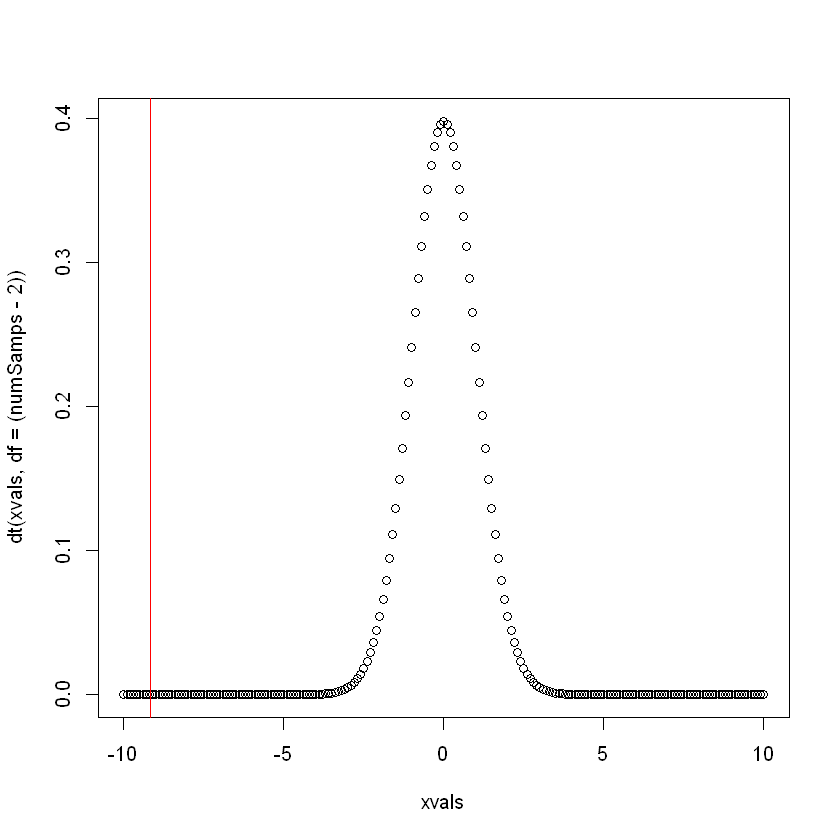

In [13]:
# extract the coefficient for beta1
coeff <- model_fit$coefficients[2]
coeff  #beta1

# calculate the standard error for beta1
seB1 <- (sqrt(sum( (model_fit$residuals) ^ 2) / (numSamps - 2))
         / sqrt(beta1Stats["var"] * numSamps))
as.numeric(seB1) #e

# find the corresponding t-statistic 
tvalue <- coeff / seB1
as.numeric(tvalue) #t-value

# plot the t-distribtion with 150 degrees of freedom and add a vertical 
# at our calculated t-statistic
xvals <- -100:100 / 10
plot(xvals, dt(xvals, df = (numSamps - 2)))
abline(v = tvalue, col = "red")

**Question 1.3 [5 points]**: From visual inspection of the plot, would you say that SCT2 is significantly differentially expressed? How would we calculate this significance value from the distribution?  What is the null hypothesis that the distribution represents? 

#### Answer:
yes SCT2 is significantly differentially expressed. We would calculate the proportion of area under the curve that is more extreme than x. The null hypothesis is that the gene is not differently expressed. (beta1 = 0)

To calculate the significance, we can use the following command:

In [14]:
pvalue <- 2 * pt(-abs(tvalue), numSamps - 2)
pvalue

beta1 
3.306011e-16

We also can have the `glm()` function return all of these significance related values by using the `summary()` function. 

In [15]:
model_summ <- summary(model_fit)
model_summ

# to extract only the beta1 pvalue from the summary result
model_summ$coefficients["beta1", "Pr(>|t|)"]


Call:
glm(formula = gene_expr ~ beta1, family = gaussian, data = data.frame(gene_expr = gene_expr, 
    beta1 = beta1))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.6139  -0.8303   0.1965   1.0135   3.6981  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  11.7571     0.1492  78.787  < 2e-16 ***
beta1        -2.3874     0.2602  -9.176 3.31e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 2.271383)

    Null deviance: 531.94  on 151  degrees of freedom
Residual deviance: 340.71  on 150  degrees of freedom
AIC: 560.04

Number of Fisher Scoring iterations: 2


[1] 3.306011e-16

Alright, so we have gone through the process of assessing whether one gene, STC2, is differentially expressed.  But there are still 2491 other genes remaining.  

**Question 1.4 [8 points]**: Calculate the pvalue of differential expression for all 2491 genes in the expression matrix.  Save the 100 most significant Entrez gene names into a vector `topDE`.  What is the most significant and least significant of those top 100 genes. Note: it takes about 15 seconds for me to run this cell using mostly built in R functions, so if it is taking much longer for you, you might have several unnecessary steps. **Also:** you may want to read **Question 1.5** before starting your implementation here.

In [16]:
### Insert Your Code Here ###
# extract gene
# numeric()
# mygene_entrez <- "8614"
# uniq_entrez_gene_info[mygene_entrez, "external_gene_name"]


gene_num = length(filtered_log2NormExpr[ , 1])
beta1_v <- numeric(gene_num)
beta1_p <- numeric(gene_num)
#names(beta1_p) = row.names(filtered_log2NormExpr)
name_p = row.names(filtered_log2NormExpr)
name_store = row.names(filtered_log2NormExpr)

for (i in 1:length(filtered_log2NormExpr[, 1])){
    gene_expr <- as.numeric(filtered_log2NormExpr[i, ])
    model_fit <- glm(gene_expr ~ beta1, family = gaussian, data = data.frame(gene_expr = gene_expr, beta1 = beta1))

    model_summ <- summary(model_fit)

    # to extract only the beta1 pvalue from the summary result
    beta1_p[i] = model_summ$coefficients["beta1", "Pr(>|t|)"]
    beta1_v[i] = model_summ$coefficients["beta1", "Estimate"]
    temp_top = row.names(filtered_log2NormExpr[i, ])
    
    name_p[i] <- uniq_entrez_gene_info[temp_top, "external_gene_name"]
    name_store[i] <- temp_top 
}




In [17]:
names(beta1_p) <- name_p
sorted_p = beta1_p[order(beta1_p)][1:100]
topDE <- names(sorted_p)
topDE[1]
topDE[100]
names(beta1_p) <- name_store
name_store = names(beta1_p[order(beta1_p)][1:100])


[1] "ABL2"

[1] "SCD"

#### Answer:
The most significant gene is "ABL2" and the least significant gene is "SCD".

**Question 1.5 [6 points]**: Create a scatterplot with 2492 points, one for each gene. Make the y-axis the `beta1` value fitted for that gene.  Make the x-axis the $-1*log10()$ of the gene's differential expression pvalue.  Plot a red vertical line showing the p.value of the 100th most significant gene.  What do you observe from this plot?  Why would some genes with larger `beta1` values not be as significant as our top 100 genes?

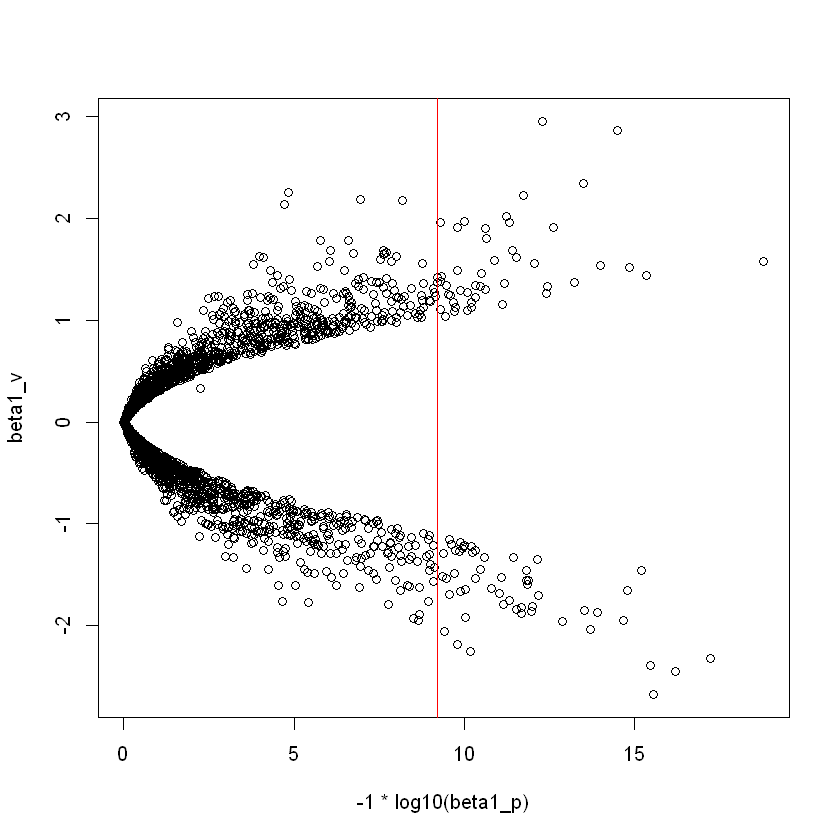

In [18]:
### Insert Your Code Here ###
plot(x = −1*log10(beta1_p)  , y = beta1_v)

abline(v = −1*log10(sorted_p[100]), col = "red")

#### Answer:
Data points to the right of the vertical line should be the 100 most significant genes. Sometimes, even beta1 values are bigger, this does not necessary indicate a lower p-value. Because the intercepts might be different as well as value of w.

### Problem 2: Gene Set Enrichment Analysis with the Fisher's Exact Test (45 points)
In the last problem, we created a set of 100 genes that were the most differentially expressed between the `Mesenchymal` and the `other` subtypes of glioblastoma tumors.  However, lists of genes are hard for biologists to interpret because it is difficult to memorize the function of tens of thousands of different genes. So, an extremely common paradigm in biological research is to subject these gene lists to enrichment analysis.  This involves finding a global collection of annotations that already relate genes to known functions.  When your gene list significantly enriches in a list of genes with known function, then you may choose to assume that the known function is also related to your genes as well.  This assumption can lead to new hypotheses to experimentally test or possible insights into the molecular mechanisms underlying your observations.

For this problem, we are going to use one of the largest, most common collection of global gene annotations, called [Gene Ontology](http://geneontology.org/). Gene Ontology (GO) is a community effort to annotate genes/proteins for their function.  They have built a hierarchy of standardized annotation terms that is used across human and many other model organisms.  Their teams relate genes to each standardized annotation using careful manual curation of research literature and advanced computational inference techniques.  We will start by downloading the Gene Ontology annotations for human genes from an Bioconductor Annotation Database [org.Hs.eg.db](https://bioconductor.org/packages/release/data/annotation/manuals/org.Hs.eg.db/man/org.Hs.eg.db.pdf). 

In [19]:
# load annotation database
library(org.Hs.eg.db)

# convert GO annotations to dataframe
go_annots <- as.data.frame(org.Hs.egGO)
dim(go_annots)
head(go_annots)

Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, w

[1] 313493      4

gene_id,go_id,Evidence,Ontology
1,GO:0002576,TAS,BP
1,GO:0008150,ND,BP
1,GO:0043312,TAS,BP
2,GO:0001869,IDA,BP
2,GO:0002576,TAS,BP
2,GO:0007597,TAS,BP


We find that there are 313493 annotations relating Entrez gene identifiers (first column) to Gene Ontology term identifiers (second column). Gene Ontology divides their hierarchy of standardized annotation terms into three distinct trees. The `Ontology` column of our go_annot data.frame shows to which tree each `go_id` term belongs, either 
- biological process (BP),
- cellular component (CC), or
- molecular function (MF).

In [20]:
sort(table(go_annots$Ontology), decreasing = T)


    BP     CC     MF 
149928  89069  74496 

The third column of our table describes the type of evidence that supports the association between the gene and the Gene Ontology Term. These include evidence types such as:
 - IEA: inferred from electronic annotation
 - IDA: inferred from direct assay
 - IBA: inferred from biological aspect of ancestor
 - TAS: traceable author statement
 - ISS: inferred from sequence similarity
 - IMP: inferred from mutant phenotype
 - IPI: inferred from physical interaction

In [21]:
sort(table(go_annots$Evidence), decreasing = T)


  IEA   IDA   IBA   TAS   ISS   IMP   IPI   NAS   HDA    ND   IGI    IC   IEP 
78701 59962 50630 46983 21629 18567 15044  7720  7173  1913  1359  1323   872 
  ISM   EXP   HMP   HEP   ISA 
  772   653   120    70     2 

As we can see below, the Gene Ontology annotations cover 19456 genes annotated with anywhere from 1 to 237 separate Gene Ontology terms and cover 17669 Gene Ontology term gene sets containing anywhere from 1 to 9510 genes.

In [22]:
geneids <- sort(table(go_annots$gene_id), decreasing = T)
length(geneids)
summary(as.integer(geneids))

goids <- sort(table(go_annots$go_id), decreasing = T)
length(goids)
summary(as.integer(goids))

[1] 19456

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    6.00   12.00   16.11   20.00  237.00 

[1] 17669

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    3.00   17.74    9.00 9510.00 

We will use these Gene Ontology annotation term gene sets and look for overlap between them and our own gene set of interest.  To begin this problem, we will create a set of random genes (that we will pretend were differentially expressed (DE)) from our GBM expression data, `geneList`, to compare to Gene Ontology sets.  This `geneList` object will have a particular structure which will make it compatible with Bioconductor packages later on.

In [23]:
# record how many genes there are in our expression data
nGenes <- dim(filtered_log2NormExpr)[1]

# create a empty gene list of that length with the Entrez gene identifiers as names
geneList <- rep(0, nGenes)
names(geneList) <- rownames(filtered_log2NormExpr)

# create a gene set of 100 random genes by setting 100 elements to 1
set.seed(1)
geneList[sample(1:dim(filtered_log2NormExpr)[2], 100)] <- 1

# turn geneList into factor for future functions
geneList <- as.factor(geneList)
length(geneList)
sum(geneList == 1)

[1] 2492

[1] 100

There is a library called `topGO` that we will use in this Problem to aid in the calculation of the significance of enrichment between the Gene Ontology gene sets and our GeneList.  The following command builds the topGOdata [object](https://bioconductor.org/packages/release/bioc/vignettes/topGO/inst/doc/topGO.pdf) ( I have commented on some of the arguments inline.

In [24]:
library(topGO)
GOdata <- new("topGOdata",
              ontology = "MF", # one of the three `Ontology` trees, this one is "Molecular Function"
              allGenes = geneList, # a factor containing the 'universe' of genes with the genes of the gene set having the score of 1
              annotationFun = annFUN.org,
              mapping = "org.Hs.eg.db", # with the above line, the annotation database to extract GO annotations
              nodeSize = 10 # the minimum gene set size for a GO annotation term gene set
              )
GOdata

Loading required package: graph
Loading required package: GO.db

Loading required package: SparseM
Warning message:
"package 'SparseM' was built under R version 3.5.2"
Attaching package: 'SparseM'

The following object is masked from 'package:base':

    backsolve


groupGOTerms: 	GOBPTerm, GOMFTerm, GOCCTerm environments built.

Attaching package: 'topGO'

The following object is masked from 'package:IRanges':

    members


Building most specific GOs .....
	( 1960 GO terms found. )

Build GO DAG topology ..........
	( 2486 GO terms and 3265 relations. )

Annotating nodes ...............
	( 2446 genes annotated to the GO terms. )



------------------------- topGOdata object -------------------------

 Description:
   -   

 Ontology:
   -  MF 

 2492 available genes (all genes from the array):
   - symbol:  4340 3119 4747 1293 5653  ...
   - 100  significant genes. 

 2446 feasible genes (genes that can be used in the analysis):
   - symbol:  4340 3119 4747 1293 5653  ...
   - 95  significant genes. 

 GO graph (nodes with at least  10  genes):
   - a graph with directed edges
   - number of nodes = 488 
   - number of edges = 632 

------------------------- topGOdata object -------------------------


From the output, we see that of the 2492 genes in our dataset, only 2446 of them were mapped in the GO annotations.  Of the 100 genes of our random gene set, only 95 were mapped in the GO annotations.  We will do all further analysis using the 2446 genes as our gene universe because these were the ones that had both expression data and annotations in GO.  We also see from the output, there are 488 annotation term gene sets from Gene Ontology that had at least 10 annotated genes in our universe and were in the "Molecular Function" ontology tree.

We can extract these kept/feasible genes in our universe, our random gene set, and a GO term gene set like GO:0008289, "lipid binding", using the following commands:

In [25]:
# genes kept in the universe
gene.universe <- genes(GOdata)
length(gene.universe)
# gene kept from random DE genes
sig.genes <- sigGenes(GOdata)
length(sig.genes)
# genes kept from lipid binding term set
go.genes <- genesInTerm(GOdata, "GO:0008289")[[1]]
length(go.genes)

[1] 2446

[1] 95

[1] 129

The way basic enrichment tests work is that they look for a significant overlap between the user gene list (our random 100) and the annotation term gene list.  They represent this overlap information as a contingency matrix.  We can create an empty continguency matrix below:

In [26]:
contTable <- matrix(NA, 2, 2, dimnames = list(c("anno", "notAnno"),
                                              c("sig", "notSig")))
contTable

,sig,notSig
anno,NA,NA
notAnno,NA,NA


**Question 2.1 [8 points]**: If 129 out of our universe of 2446 genes have the annotation for "lipid binding", what is the expectation for the number of our 95 `sig.genes` to have that annotation by random chance?  For our `gene.universe`, `sig.genes`, and `go.genes` lists, fill out the four NA values in the contingency table, `contTable`.  For this particular problem, I used the `intersect()` and `setdiff()` functions to find the overlaps between the different combinations of the gene sets and their negations. To check that your numbers make sense, the sum(contTable) should equal all 2446 genes that were kept. How does your observations in `contTable` compare to the expected values you estimated in the first part?

In [27]:
### Insert Your Code Here ###


contTable["anno", "sig"] <-  length(intersect(go.genes,sig.genes))     ### Insert Your Code Here ###

contTable["notAnno", "sig"] <-  length(intersect(setdiff(gene.universe, go.genes),sig.genes))    ### Insert Your Code Here ###

contTable["anno", "notSig"] <- length(intersect(go.genes,setdiff(gene.universe, sig.genes) ))  ### Insert Your Code Here ###
                                            
contTable["notAnno", "notSig"] <- length( intersect(setdiff(gene.universe, go.genes),setdiff(gene.universe, sig.genes) ))  ### Insert Your Code Here ###
                                                  
sum(contTable)
contTable

### Insert Your Code Here ###

[1] 2446

,sig,notSig
anno,10,119
notAnno,85,2232


#### Answer:
95*129/2446 = 5 genes are expected to have that annotation. As shown in the table above, 10 genes are annotated, which is close to our estimation.

Once we have built the contingency table, we can use a statistical test called the Fisher's exact [test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) to calculate the significance of the overlap.

In [28]:
fisher_result <- fisher.test(x = contTable, alternative = "greater")
fisher_result


	Fisher's Exact Test for Count Data

data:  contTable
p-value = 0.0257
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 1.132782      Inf
sample estimates:
odds ratio 
  2.205562 


**Question 2.2 [5 points]**: What is significance of the enrichment between our random DE gene set and our lipid binding GO gene set?  What is the null hypothesis of the Fisher's exact test?  What would it mean if we set the `alternative=` alternative hypothesis to `less` or `two.sided`?  

#### Answer:
1. p-value is 0.0257
2. The null hypothesis is the two sets are independent
3. two sided means a two-sided fisher test. less means the odds ratio is less than one.

So we have done one enrichment test, but if you remember back to when we created the `GOdata` object, there are 488 Gene Ontology sets in the Molecular Function ontology that are of a reasonable size.  Rather than relying directly on the `fisher.test()` call for each of these, we can use the `topGO` library functions.  The `runTest()` runs the Fisher's exact test on each of the GO terms ("Nontrivial nodes" are GO terms that have at least 1 of our random DE genes in them.)

In [29]:
# runs all tests for all GO terms
resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
resultFisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 317 nontrivial nodes
		 parameters: 
			 test statistic: fisher



Description:  
Ontology: MF 
'classic' algorithm with the 'fisher' test
488 GO terms scored: 11 terms with p < 0.01
Annotation data:
    Annotated genes: 2446 
    Significant genes: 95 
    Min. no. of genes annotated to a GO: 10 
    Nontrivial nodes: 317 

The `GenTable()` function summarizes the results in a sorted table. We can control the number of returned results by setting the `topNodes=` argument.

In [30]:
# create results table dataframe
allRes <- GenTable(GOdata, classicFisher = resultFisher,
                   orderBy = "classicFisher", ranksOf = "classicFisher",
                   topNodes = 20)
allRes
allRes$Significant[1]/allRes$Expected[1]

GO.ID,Term,Annotated,Significant,Expected,classicFisher
GO:0005509,calcium ion binding,95,13,3.69,5e-05
GO:0031406,carboxylic acid binding,37,7,1.44,0.00042
GO:0043177,organic acid binding,38,7,1.48,0.00050
GO:0005504,fatty acid binding,11,4,0.43,0.00057
GO:0048018,receptor ligand activity,51,7,1.98,0.00305
GO:0033293,monocarboxylic acid binding,17,4,0.66,0.00344
GO:0005201,extracellular matrix structural constitu...,19,4,0.74,0.00528
GO:0030545,receptor regulator activity,57,7,2.21,0.00575
GO:0005539,glycosaminoglycan binding,33,5,1.28,0.00796
GO:0043167,ion binding,1033,52,40.12,0.00828


[1] 3.523035

**Question 2.3 [6 points]**: Based on the previous few cells how many GO terms are significantly associated with our random DE gene set? What are some general molecular functions they seem to relate to?  What is the fold enrichment (`Significant`/`Expected`) of the most related GO term?

#### Answer:
p<0.01 is significantly associated. 11 terms are associated with random DE gene set.Some examples of molecular functions are calcium ion binding and acid bindings. Fold enrichment is 13/3.69 = 3.523.

We can extract all of the significance pvalues and reorder them with the following commands:

In [31]:
# get named pvals in sorted order
pValue.classic <- score(resultFisher)
pValue.classic <- pValue.classic[order(pValue.classic)]
head(pValue.classic)

GO:0005509   GO:0031406   GO:0043177   GO:0005504   GO:0048018   GO:0033293 
5.039371e-05 4.228584e-04 5.020821e-04 5.716594e-04 3.046182e-03 3.444198e-03

**Question 2.4 [5 points]**: What would you expect for the distribution of pvalues like the `pValue.classic` values? Plot the histogram of `pValue.classic` values and explain why or why not it matches your expectation?

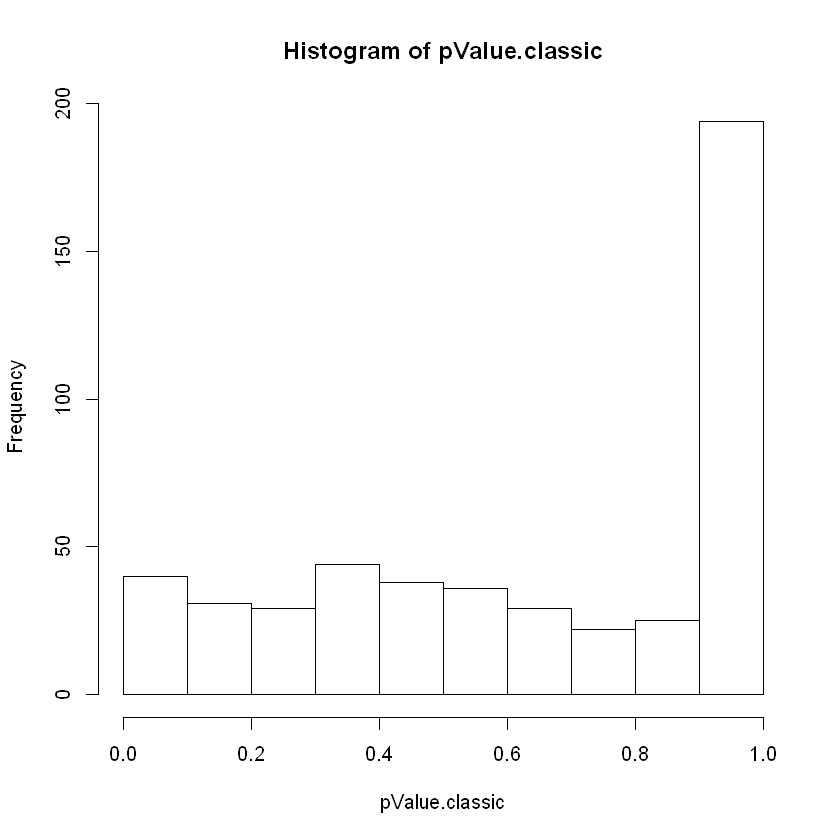

In [32]:
### Insert Your Code Here ###
hist(pValue.classic)

#### Answer:
I would expect most of p-values to be close to 1, because most sets should be not associated with random DEgene set. Yes the histogram matches my expectation

Another useful feature of the `topGO` library is that we can plot the part of the Ontology tree that contains the most significant enrichment results.  For example:

Loading required package: Rgraphviz
Loading required package: grid

Attaching package: 'grid'

The following object is masked from 'package:topGO':

    depth


Attaching package: 'Rgraphviz'

The following objects are masked from 'package:IRanges':

    from, to

The following objects are masked from 'package:S4Vectors':

    from, to



$dag
A graphNEL graph with directed edges
Number of Nodes = 10 
Number of Edges = 10 

$complete.dag
[1] "A graph with 10 nodes."


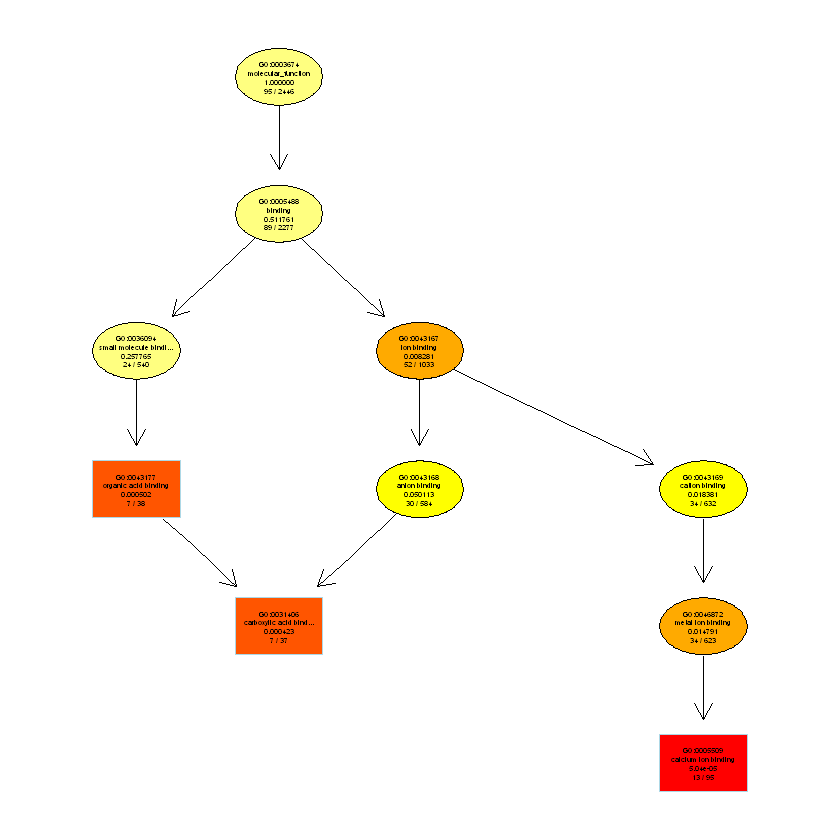

In [33]:
# top 3 GO terms in rectangles, most signif (red) to least (yellow),
showSigOfNodes(GOdata, score(resultFisher), firstSigNodes = 3, useInfo = "all")

**Question 2.5 [5 points]**: What do you notices about the top three significantly enriched terms?  What about the terms they are connected to?

#### Answer:
The three significantly enriched terms contain the rest of the significantly enriched terms.

We have conducted 488 enrichment tests, so it is appropriate to do multiple hypothesis testing correction. We will do the simplest (and one of the harshest) which is called the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction).  The basic idea is that you should adjust the pvalues by multiplying each pvalue by the total number of statistical tests.

**Question 2.6 [6 points]**: What are the Bonferroni corrected significance values for the top 5 Gene Ontology terms?  How many terms would you consider significant after this harsh correction? What is one drawback of using Bonferroni for multiple hypothesis test correction?

In [34]:
### Insert Your Code Here ###
adjusted_pValue <- pValue.classic*488
head(adjusted_pValue)

GO:0005509 GO:0031406 GO:0043177 GO:0005504 GO:0048018 GO:0033293 
0.02459213 0.20635488 0.24501607 0.27896980 1.48653705 1.68076880

#### Answer:
The top 5 Gene Ontology terms(ordered) are shown above. After the adjustment, none of the terms would be considered significant. The drawback is that more Type II errors will be made.

**Question 2.7 [10 points]**: Time to put it all together.  What are the top enriched GO terms from the Molecular Function (MF) ontology for our 100 `topDE` genes we found in Question 1.4?  Do they relate to any particular general functions?  Are they significant after Bonferroni correction?

In [35]:
### Insert Your Code Here ###


geneList2 <- geneList



for(i in 1:length(geneList)){
    if(names(geneList[i]) %in% name_store)
        geneList2[i] = 1
    else
        geneList2[i] = 0
    
}

GOdata1 <- new("topGOdata",
              ontology = "MF", # one of the three `Ontology` trees, this one is "Molecular Function"
              allGenes = geneList2, # a factor containing the 'universe' of genes with the genes of the gene set having the score of 1
              annotationFun = annFUN.org,
              mapping = "org.Hs.eg.db", # with the above line, the annotation database to extract GO annotations
              nodeSize = 10 # the minimum gene set size for a GO annotation term gene set
              )
GOdata1



Building most specific GOs .....
	( 1960 GO terms found. )

Build GO DAG topology ..........
	( 2486 GO terms and 3265 relations. )

Annotating nodes ...............
	( 2446 genes annotated to the GO terms. )



------------------------- topGOdata object -------------------------

 Description:
   -   

 Ontology:
   -  MF 

 2492 available genes (all genes from the array):
   - symbol:  4340 3119 4747 1293 5653  ...
   - 100  significant genes. 

 2446 feasible genes (genes that can be used in the analysis):
   - symbol:  4340 3119 4747 1293 5653  ...
   - 99  significant genes. 

 GO graph (nodes with at least  10  genes):
   - a graph with directed edges
   - number of nodes = 488 
   - number of edges = 632 

------------------------- topGOdata object -------------------------


In [36]:

resultFisher <- runTest(GOdata1, algorithm = "classic", statistic = "fisher")
pValue.classic <- score(resultFisher)
pValue.classic <- pValue.classic[order(pValue.classic)]
head(pValue.classic)



			 -- Classic Algorithm -- 

		 the algorithm is scoring 329 nontrivial nodes
		 parameters: 
			 test statistic: fisher


GO:0005070  GO:0004709  GO:0004702  GO:0004714  GO:0035591  GO:0005057 
0.006124929 0.006247027 0.006824663 0.014378987 0.019018420 0.025768252

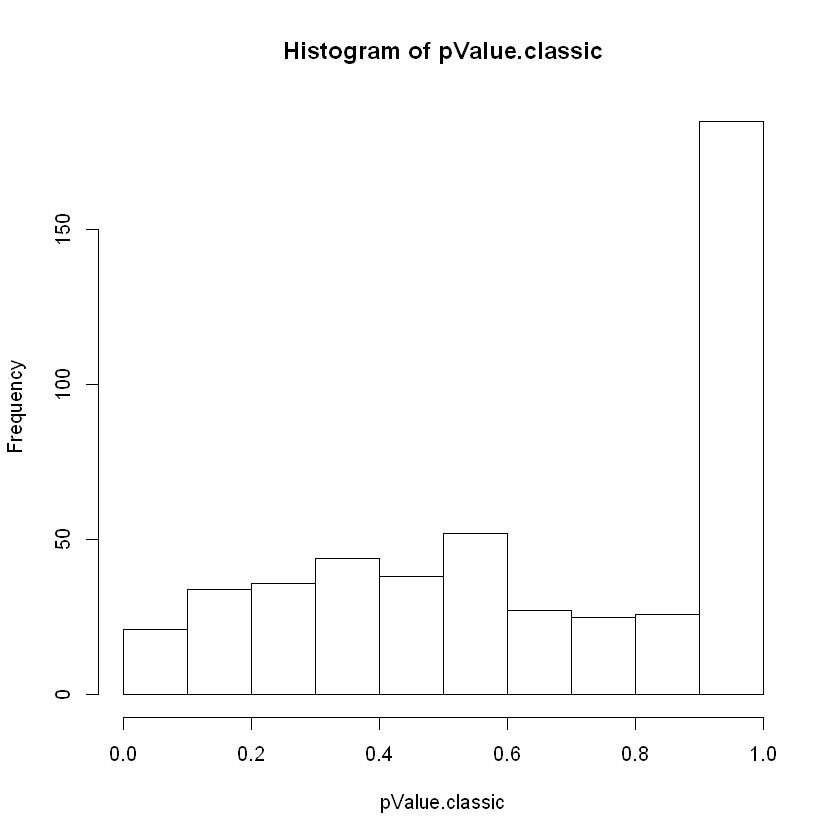

$dag
A graphNEL graph with directed edges
Number of Nodes = 19 
Number of Edges = 23 

$complete.dag
[1] "A graph with 19 nodes."


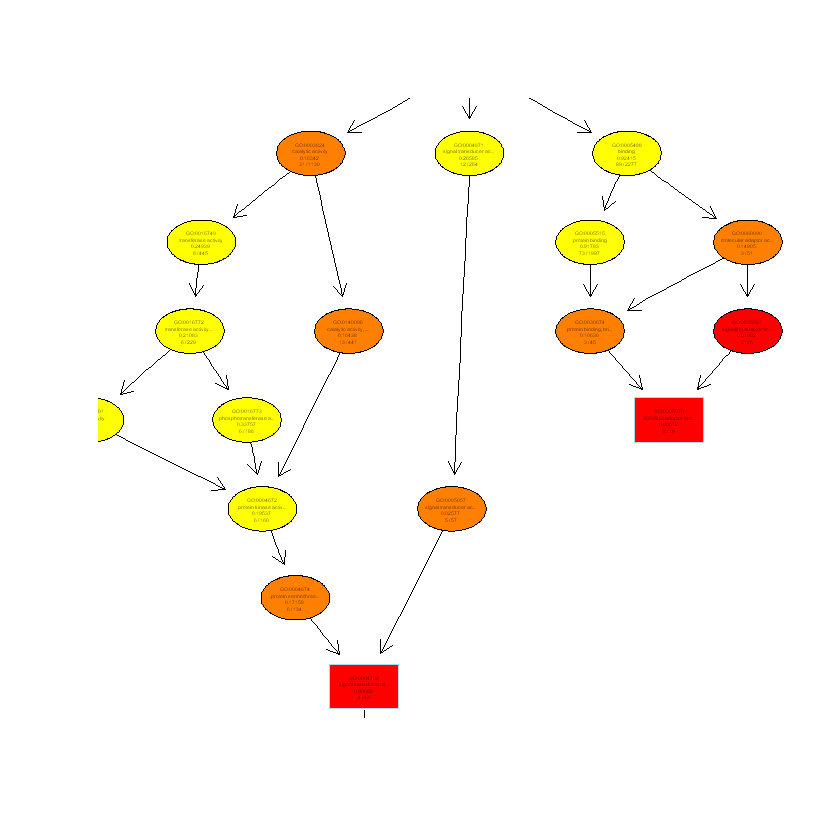

In [37]:
hist(pValue.classic)
showSigOfNodes(GOdata, score(resultFisher), firstSigNodes = 3, useInfo = "all")

In [38]:
allRes <- GenTable(GOdata, classicFisher = resultFisher,
                   orderBy = "classicFisher", ranksOf = "classicFisher",
                   topNodes = 20)
allRes
allRes$Significant[1]/allRes$Expected[1]

GO.ID,Term,Annotated,Significant,Expected,classicFisher
GO:0005070,SH3/SH2 adaptor activity,19,2,0.74,0.0061
GO:0004709,MAP kinase kinase kinase activity,30,3,1.17,0.0062
GO:0004702,"signal transducer, downstream of recepto...",43,4,1.67,0.0068
GO:0004714,transmembrane receptor protein tyrosine ...,24,3,0.93,0.0144
GO:0035591,signaling adaptor activity,26,2,1.01,0.0190
GO:0005057,"signal transducer activity, downstream o...",57,5,2.21,0.0258
GO:0019199,transmembrane receptor protein kinase ac...,29,4,1.13,0.0275
GO:0031434,mitogen-activated protein kinase kinase ...,29,3,1.13,0.0275
GO:0004713,protein tyrosine kinase activity,49,4,1.90,0.0457
GO:0016741,"transferase activity, transferring one-c...",21,0,0.82,0.0504


[1] 2.702703

In [39]:
adjusted_pValue <- pValue.classic*488
head(adjusted_pValue)

GO:0005070 GO:0004709 GO:0004702 GO:0004714 GO:0035591 GO:0005057 
  2.988965   3.048549   3.330435   7.016946   9.280989  12.574907

#### Answer:
The top enriched GO terms from the Molecular Function (MF) ontology are shown above. They relate to several functions such as kinase activities. They are not significant after Bonderroni correction. 

### Problem 3: Gene Co-Expression Clusters (35 bonus points)
Finally, we will use correlation relationships between genes to build co-expression gene modules (sets). There are many methods for building these co-expression networks but we will focus on one popular option [WGCNA](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/). We will use our GBM expression dataset and the WGCNA algorithm to build gene modules and then test those modules for enrichment to Gene Ontology annotations.

First, we reload the data.

In [40]:
expr_file <- "TCGA-GBM.log2norm.2492genes.entrez.txt"
log2NormExpr <- read.table(expr_file, sep = "\t", header = T, row.names = 1,
                           stringsAsFactors = F)
dim(log2NormExpr)
log2NormExpr[1:5, 1:5]

[1] 2492  155

,TCGA.02.2483,TCGA.06.2558,TCGA.06.5413,TCGA.06.0744,TCGA.41.2572
4340,5.86707,10.20860,12.52460,7.01528,9.73468
3119,8.12704,11.59350,14.06810,9.04885,12.23580
4747,5.77170,12.40060,8.37827,10.25210,9.86113
1293,5.97804,11.71670,9.04709,9.48972,8.59887
5653,10.69530,7.80236,11.48920,11.91510,6.84002


Next we load the WCGNA library and default options.

In [41]:
library(WGCNA)
options(stringsAsFactors = FALSE);
enableWGCNAThreads()

Warning message:
"package 'WGCNA' was built under R version 3.5.3"Loading required package: dynamicTreeCut
Warning message:
"package 'dynamicTreeCut' was built under R version 3.5.2"Loading required package: fastcluster
Warning message:
"package 'fastcluster' was built under R version 3.5.2"
Attaching package: 'fastcluster'

The following object is masked from 'package:stats':

    hclust


Attaching package: 'WGCNA'

The following object is masked from 'package:IRanges':

    cor

The following object is masked from 'package:S4Vectors':

    cor

The following object is masked from 'package:stats':

    cor



Allowing parallel execution with up to 3 working processes.


The WGCNA works by first calculating a similarity matrix with values for every pair of genes that captures their absolute correlation.  Rather than normal correlation measures, WGCNA calculates a specialize biweight midcorrelation measure with the `bicor()` [function](https://www.rdocumentation.org/packages/WGCNA/versions/1.66/topics/bicor).  The results after this first step are as follows:

In [42]:
sim_mat <- abs(bicor(t(log2NormExpr)))
dim(sim_mat)
sim_mat[1:5, 1:5]

[1] 2492 2492

,4340,3119,4747,1293,5653
4340,1.00000000,0.9770895,0.09839374,0.1123370,0.1311944
3119,0.97708951,1.0000000,0.10414521,0.1218930,0.1126213
4747,0.09839374,0.1041452,1.00000000,0.9634425,0.1085717
1293,0.11233699,0.1218930,0.96344254,1.0000000,0.1233165
5653,0.13119438,0.1126213,0.10857171,0.1233165,1.0000000


The next important feature of WGNCA is that they raise this similarity matrix to an exponential power.  The reason for this is that they believe that biological networks should have the scale-free [properties](https://en.wikipedia.org/wiki/Scale-free_network).  At different powers, the contribution of small correlation values is lessened and the network begins to look more and more like a scale free ideal.  WGCNA leaves it to the user to select the appropriate "soft thresholding" power before running a clustering algorithm.  We will create plots to compare the different values of the soft thresholding powers in the next cell.

pickSoftThreshold: will use block size 2492.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2492 of 2492
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0482  0.626          0.904 411.000  409.0000 675.00
2      2   0.2070 -0.654          0.952 114.000  106.0000 268.00
3      3   0.6270 -1.190          0.982  41.900   35.4000 140.00
4      4   0.8210 -1.510          0.986  18.900   14.0000  88.10
5      5   0.8310 -1.680          0.942   9.810    6.4500  61.40
6      6   0.9290 -1.620          0.982   5.690    3.1200  45.20
7      7   0.9530 -1.620          0.984   3.580    1.6300  35.30
8      8   0.9510 -1.640          0.975   2.400    0.9250  29.50
9      9   0.9520 -1.650          0.977   1.690    0.5460  25.00
10    10   0.9390 -1.650          0.960   1.240    0.3330  21.40
11    12   0.9500 -1.630          0.981   0.730    0.1290  16.10
12    14   0.9480 -1.610          0.974   0.472    0.0533  12.60


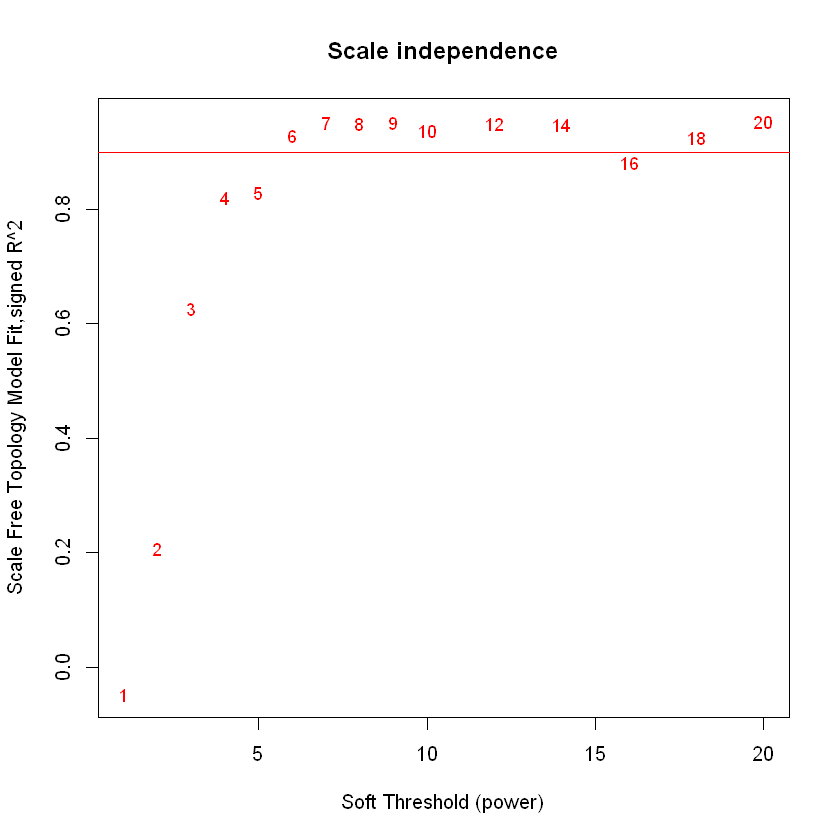

In [43]:
# Choose a set of possible soft-thresholding powers
powers <- c(c(1:10), seq(from = 12, to = 20, by = 2))

# Call the network topology analysis function
sft <- pickSoftThreshold(t(log2NormExpr), powerVector = powers, verbose = 5)

# Plot the results:
cex1 <- 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[, 1], -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     xlab = "Soft Threshold (power)",
     ylab = "Scale Free Topology Model Fit,signed R^2",
     type = "n", main = paste("Scale independence"));
text(sft$fitIndices[, 1], -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     labels = powers, cex = cex1, col = "red");

# this line corresponds to using an R^2 cut-off of h
abline(h = 0.90, col = "red")


**Question 3.1 [5 bonus points]**: Look at the plot above.  For each different tested power it shows the r-squared fit of a model using that power to a scale-free network ideal.  What power level does the r-squared stop improving? What power level is the first with an r-square greater than 0.9 (red line)?

#### Answer:
At round 7 power level, the r-squared stop improving. At 6 power level, an r-square is greater than 0.9 for the first time.

After deciding a power to raise the correlations to, WGNCA transforms the similar matrix using that power and then converts the similarity matrix into a dissimilarity one.

In [44]:
beta <- 6 # selected power from the previous question
adjacency <- sim_mat ^ beta
dissimilarity <- 1 - adjacency
dim(dissimilarity)
dissimilarity[1:5, 1:5]

[1] 2492 2492

,4340,3119,4747,1293,5653
4340,1.332268e-15,1.298260e-01,0.9999991,0.9999980,0.9999949
3119,1.298260e-01,6.661338e-16,0.9999987,0.9999967,0.9999980
4747,9.999991e-01,9.999987e-01,0.0000000,0.2002488,0.9999984
1293,9.999980e-01,9.999967e-01,0.2002488,0.0000000,0.9999965
5653,9.999949e-01,9.999980e-01,0.9999984,0.9999965,0.0000000


Finally WGCNA runs some version of hierarchical clustering on the transformed data, like so: 

 ..cutHeight not given, setting it to 0.994  ===>  99% of the (truncated) height range in dendro.
 ..done.


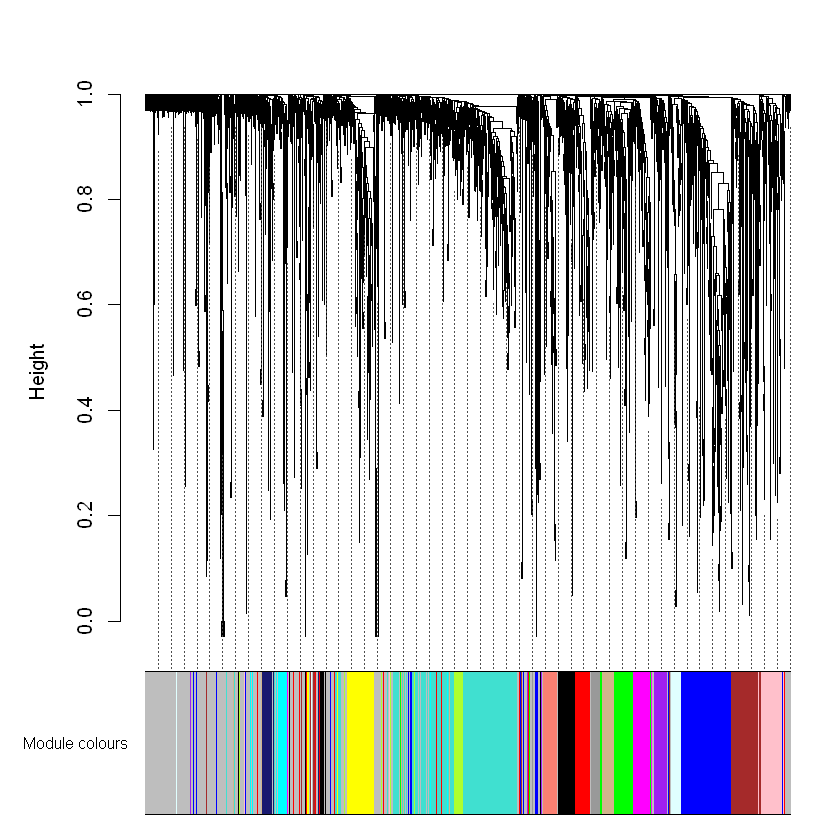

In [45]:
#create gene tree by average linkage hierarchical clustering
geneTree <- hclust(as.dist(dissimilarity ), method = "average")

#module identification using dynamic tree cut algorithm
modules <- cutreeDynamic(dendro = geneTree, distM = dissimilarity,
                         deepSplit = 4, pamRespectsDendro = FALSE,
                         minClusterSize = 30)

#assign module colours
module.colours <- labels2colors(modules)

#plot the dendrogram and corresponding colour bars underneath
plotDendroAndColors(geneTree, module.colours, "Module colours",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05, main = "")

This plot show the dendrogram that was found that relates the genes in a hierarchical clustering.  The colors underneath the dendrogram represent gene cluster membership using the WGCNA dynamic tree cutting [algorithm](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/BranchCutting/Supplement.pdf).

We have quickly gone through the basic steps of the WGCNA algorithm, but for most advanced default clustering procedures we can actually call the whole WGCNA procedure with a single command (see the [docs](https://www.rdocumentation.org/packages/WGCNA/versions/1.67/topics/blockwiseModules)).

In [46]:
net <- blockwiseModules(t(log2NormExpr),       # our expression data
                        power = beta,          # the soft thresholding power we chose from the plot
                        corType = "pearson",   # type of correlation
                        TOMType = "unsigned",  # ignores the sign of the correlation
                        minModuleSize = 30,    # minimum number of genes allowed in their own cluster
                        randomSeed = 1,        # random seed to fix our result                
                        reassignThreshold = 0, # the rest are default parameters for create clusters and formatting outputs
                        mergeCutHeight = 0.25,
                        numericLabels = TRUE, 
                        pamRespectsDendro = FALSE,
                        saveTOMs = TRUE, 
                        verbose = 3)
head(net$colors)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file blockwiseTOM-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 16 genes from module 1 because their KME is too low.
     ..removing 35 genes from module 2 because their KME is too low.
     ..removing 4 genes from module 3 because their KME is too low.
     ..removing 1 genes from module 4 because their KME is too low.
     ..removing 2 genes from module 5 because their KME is too low.
     ..removing 1 genes from module 6 because their KME is too low.
     ..removing 3 genes from module 8 because 

4340  3119  4747  1293  5653 11075 
    2     2     9     9     2     5

There are many components in the `net` output object.  However, we are most interested in the gene cluster assignments which are found in `net$colors`. Each Entrez gene will be mapped to a cluster (represented by an integer). Most of these clusters can be represented by an average expression pattern that the genes are highly correlated to.  We also will have the "unassigned" cluster 0, which contains left over genes that do not strongly correlate to any cluster expression pattern.

**Question 3.2 [5 bonus points]**: How many clusters are returned by the single step WGCNA run?  What is the size of the largest cluster? the smallest?  How many genes were not assigned to a cluster with a gene expression pattern?

In [47]:
### Insert Your Code Here ###
#net$colors
unassigned = 0
num_cluster = 0
for(i in 1:length(net$colors)){
    if(net$colors[i] == 0)
        unassigned = unassigned+1
    if(net$colors[i] > num_cluster)
        num_cluster = net$colors[i]
}
unassigned
unname(num_cluster)
count <- numeric(num_cluster)

for(i in 1:length(net$colors)){
    if(net$colors[i] != 0)
        count[net$colors[i]] = count[net$colors[i]] + 1
}

max(count)
min(count)

[1] 481

[1] 11

[1] 636

[1] 32

#### Answer:
11 clusters are returned by the single step WGCNA run. The size of the largest cluster is 636 and the size of the smallest one is 32. 481 genes were not assigned to a cluster.

We can also plot the dendrogram and the final clustering of the single step WGCNA run. The grey cluster is the unassigned cluster 0.

[1] "grey"        "turquoise"   "blue"        "brown"       "yellow"     
 [6] "green"       "red"         "black"       "pink"        "magenta"    
[11] "purple"      "greenyellow"

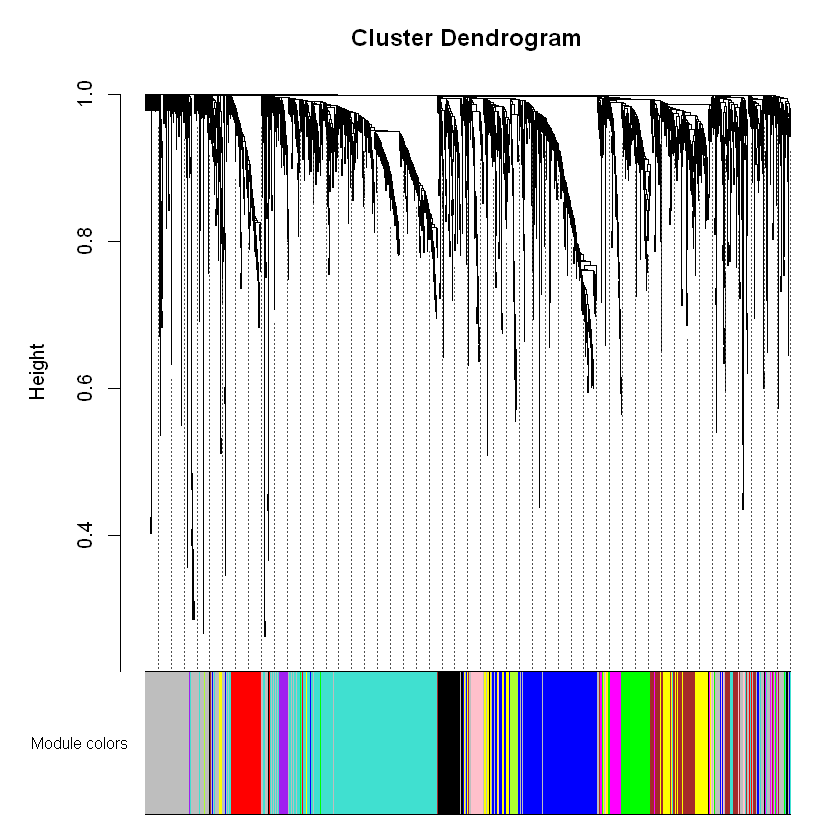

In [48]:
# Convert labels to colors for plotting
labels2colors(0:max(net$colors))
mergedColors <- labels2colors(net$colors)
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

**Question 3.3 [5 bonus points]**: Look at the plot above.  Which colored clusters seem to have the most genes with very similar expression patterns?  If you lowered the cut height, would you expect more or less clusters?

#### Answer: 
The turquoise colored cluster has the most genes with similar expression patterns. If the cut height is lowered, I would expect more clusters.

If we wanted to run Gene Ontology enrichment tests for the brown cluster (cluster number 3). We can use the same data and functions from the previous problem.

In [49]:
geneList3 <- as.factor( (net$colors == 3) * 1)
GOdata <- new("topGOdata",
              ontology = "CC",
              allGenes = geneList3,
              annotationFun = annFUN.org,
              mapping = "org.Hs.eg.db",
              nodeSize = 10
)
GOdata
resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
resultFisher
allRes <- GenTable(GOdata, classicFisher = resultFisher,
                   orderBy = "classicFisher", ranksOf = "classicFisher",
                   topNodes = 10)
allRes



Building most specific GOs .....
	( 1072 GO terms found. )

Build GO DAG topology ..........
	( 1385 GO terms and 2611 relations. )

Annotating nodes ...............
	( 2479 genes annotated to the GO terms. )



------------------------- topGOdata object -------------------------

 Description:
   -   

 Ontology:
   -  CC 

 2492 available genes (all genes from the array):
   - symbol:  4340 3119 4747 1293 5653  ...
   - 202  significant genes. 

 2479 feasible genes (genes that can be used in the analysis):
   - symbol:  4340 3119 4747 1293 5653  ...
   - 202  significant genes. 

 GO graph (nodes with at least  10  genes):
   - a graph with directed edges
   - number of nodes = 452 
   - number of edges = 862 

------------------------- topGOdata object -------------------------



			 -- Classic Algorithm -- 

		 the algorithm is scoring 410 nontrivial nodes
		 parameters: 
			 test statistic: fisher



Description:  
Ontology: CC 
'classic' algorithm with the 'fisher' test
452 GO terms scored: 4 terms with p < 0.01
Annotation data:
    Annotated genes: 2479 
    Significant genes: 202 
    Min. no. of genes annotated to a GO: 10 
    Nontrivial nodes: 410 

GO.ID,Term,Annotated,Significant,Expected,classicFisher
GO:0030027,lamellipodium,61,14,4.97,0.00026
GO:0005796,Golgi lumen,20,6,1.63,0.00399
GO:0098858,actin-based cell projection,57,11,4.64,0.00520
GO:0030175,filopodium,38,8,3.10,0.00976
GO:0042734,presynaptic membrane,18,5,1.47,0.01216
GO:0015629,actin cytoskeleton,113,16,9.21,0.01862
GO:0030424,axon,127,17,10.35,0.02587
GO:0098590,plasma membrane region,208,25,16.95,0.02716
GO:0005622,intracellular,2295,194,187.01,0.02753
GO:0048471,perinuclear region of cytoplasm,168,21,13.69,0.02833


**Question 3.4 [7 bonus points]**: Run the Cellular Component (CC) Gene Ontology enrichment tests for each WGCNA cluster. Track the most significant (top 1) pvalue for each cluster?  What is the range and the mean of these top 1 pvalues? 

In [50]:
### Insert Your Code Here ###
pvalue_store <- numeric(num_cluster)
for( i in 1:num_cluster){
    geneList3 <- as.factor( (net$colors == i) * 1)
    GOdata <- new("topGOdata",
              ontology = "CC",
              allGenes = geneList3,
              annotationFun = annFUN.org,
              mapping = "org.Hs.eg.db",
              nodeSize = 10
    )
    resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
    pValue.classic <- score(resultFisher)
    pvalue_store[i] = min(pValue.classic)
}


Building most specific GOs .....
	( 1072 GO terms found. )

Build GO DAG topology ..........
	( 1385 GO terms and 2611 relations. )

Annotating nodes ...............
	( 2479 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 452 nontrivial nodes
		 parameters: 
			 test statistic: fisher

Building most specific GOs .....
	( 1072 GO terms found. )

Build GO DAG topology ..........
	( 1385 GO terms and 2611 relations. )

Annotating nodes ...............
	( 2479 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 434 nontrivial nodes
		 parameters: 
			 test statistic: fisher

Building most specific GOs .....
	( 1072 GO terms found. )

Build GO DAG topology ..........
	( 1385 GO terms and 2611 relations. )

Annotating nodes ...............
	( 2479 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 410 nontrivial nodes
		 parameters: 
			 test statistic: fisher



In [51]:
pvalue_store
range(pvalue_store)
mean(pvalue_store)

[1] 0.0031256211 0.0022861056 0.0002610893 0.0176080242 0.0223809051
 [6] 0.0007452575 0.0007682918 0.0001776278 0.0041836605 0.0117354919
[11] 0.0088755022

[1] 0.0001776278 0.0223809051

[1] 0.006558871

#### Answer:
The most significant pvalues are shown above in the first two rows. The range is from 0.000177627812236358 to 0.022380905101168. The mean is 0.00655887064511757.

**Question 3.5 [6 bonus points]**: Rerun the single step WGCNA the same as before but with setting the `power=` argument to 1.  How does the range and mean of the top 1 pvalues change?  How does the number of clusters and their sizes change?

In [75]:
### Insert Your Code Here ###

### Insert Your Code Here ###
beta <- 1 # selected power from the previous question
adjacency <- sim_mat ^ beta
dissimilarity <- 1 - adjacency
dim(dissimilarity)
dissimilarity[1:5, 1:5]

#create gene tree by average linkage hierarchical clustering
geneTree <- hclust(as.dist(dissimilarity ), method = "average")

#module identification using dynamic tree cut algorithm
modules <- cutreeDynamic(dendro = geneTree, distM = dissimilarity,
                         deepSplit = 4, pamRespectsDendro = FALSE,
                         minClusterSize = 30)

#assign module colours
module.colours <- labels2colors(modules)


net <- blockwiseModules(t(log2NormExpr),       # our expression data
                        power = beta,          # the soft thresholding power we chose from the plot
                        corType = "pearson",   # type of correlation
                        TOMType = "unsigned",  # ignores the sign of the correlation
                        minModuleSize = 30,    # minimum number of genes allowed in their own cluster
                        randomSeed = 1,        # random seed to fix our result                
                        reassignThreshold = 0, # the rest are default parameters for create clusters and formatting outputs
                        mergeCutHeight = 0.25,
                        numericLabels = TRUE, 
                        pamRespectsDendro = FALSE,
                        saveTOMs = TRUE, 
                        verbose = 3)

unassigned = 0
num_cluster = 0
for(i in 1:length(net$colors)){
    if(net$colors[i] == 0)
        unassigned = unassigned+1
    if(net$colors[i] > num_cluster)
        num_cluster = net$colors[i]
}
unassigned
unname(num_cluster)
count <- numeric(num_cluster)

for(i in 1:length(net$colors)){
    if(net$colors[i] != 0)
        count[net$colors[i]] = count[net$colors[i]] + 1
}

pvalue_store <- numeric(num_cluster)
for( i in 1:num_cluster){
    geneList3 <- as.factor( (net$colors == i) * 1)
    GOdata <- new("topGOdata",
              ontology = "CC",
              allGenes = geneList3,
              annotationFun = annFUN.org,
              mapping = "org.Hs.eg.db",
              nodeSize = 10
    )
    resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
    pValue.classic <- score(resultFisher)
    pvalue_store[i] = min(pValue.classic)
}

[1] 2492 2492

,4340,3119,4747,1293,5653
4340,2.220446e-16,2.291049e-02,0.90160626,0.88766301,0.8688056
3119,2.291049e-02,1.110223e-16,0.89585479,0.87810699,0.8873787
4747,9.016063e-01,8.958548e-01,0.00000000,0.03655746,0.8914283
1293,8.876630e-01,8.781070e-01,0.03655746,0.00000000,0.8766835
5653,8.688056e-01,8.873787e-01,0.89142829,0.87668350,0.0000000


 ..cutHeight not given, setting it to 0.915  ===>  99% of the (truncated) height range in dendro.
 ..done.
 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file blockwiseTOM-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 50 genes from module 1 because their KME is too low.
     ..removing 153 genes from module 2 because their KME is too low.
     ..removing 93 genes from module 3 because their KME is too low.
     ..removing 51 genes from module 4 because their KME is too low.
     ..removing 21 genes from module 5 because their KME is too low.
   

[1] 371

[1] 13


Building most specific GOs .....
	( 1072 GO terms found. )

Build GO DAG topology ..........
	( 1385 GO terms and 2611 relations. )

Annotating nodes ...............
	( 2479 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 451 nontrivial nodes
		 parameters: 
			 test statistic: fisher

Building most specific GOs .....
	( 1072 GO terms found. )

Build GO DAG topology ..........
	( 1385 GO terms and 2611 relations. )

Annotating nodes ...............
	( 2479 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 426 nontrivial nodes
		 parameters: 
			 test statistic: fisher

Building most specific GOs .....
	( 1072 GO terms found. )

Build GO DAG topology ..........
	( 1385 GO terms and 2611 relations. )

Annotating nodes ...............
	( 2479 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 428 nontrivial nodes
		 parameters: 
			 test statistic: fisher



In [76]:
range(pvalue_store)
unname(num_cluster)
count

[1] 0.0008231259 0.0246877217

[1] 13

[1] 660 306 303 212 193  95  90  75  44  40  38  35  30

#### Answer:
The new range is from 0.000823125882675135 to 0.0246877217127972. The number of clusters is now 13, which increases compared to power of 6. The size of the largest cluster increases while the size of the smallest cluster decreases.

**Question 3.6 [7 bonus points]**: WGCNA also provides some functions to allow us to more closely examine the relationship between the expression patterns of the different clusters.   We can use as representative profiles for each cluster, the first principal component of the standardized expression profiles, sometimes called the eigengene. Follow the tutorial 5.b [here](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/FemaleLiver-05-Visualization.pdf), to plot the dendrogram of similarity between the gene module eigengenes.  Also, plot the eigengene adjacency heatmap, as is done in Figure 2.  Which pairs of clusters are the most related by eigengene similarity?  Is there a pair of clusters whose eigengene representative profiles are extremely anti-correlated?

#### Answer:


### Bonus Problem 4: AMARETTO (10 bonus points)

In this problem, we will run a different algorithm for finding gene co-expression modules from gene expression data. This new method AMARETTO ([github](https://github.com/gevaertlab/AMARETTO), [tutorial](https://bioconductor.org/packages/devel/bioc/vignettes/AMARETTO/inst/doc/amaretto.pdf), [bioconductor](https://bioconductor.org/packages/devel/bioc/html/AMARETTO.html) ) primarily differs from WGCNA in that it 1) separates genes into two classes targets and regulators and 2) uses regression to model the representative profile of a gene module as a linear combination of regulator expression profiles. We will run AMARETTO on their sample dataset from the Cancer Cell Line Encyclopedia ([CCLE](https://portals.broadinstitute.org/ccle/about)) and examine the resulting modules through their html summaries.

First, we must install and load the library (may take tens of minutes the first time). Then we will load in the necessary sample datasets. Next, we set up our run parameters.

In [85]:
if(!"AMARETTO" %in% existing_packages){
    # install AMARETTO from github with devtools library
    library(devtools)
   # Sys.setenv(TAR = "C:\\WINDOWS\\SYSTEM32\\tar.exe")
    options(unzip = "internal")
    devtools::install_github("gevaertlab/AMARETTO", ref="for35_develop", dependencies=TRUE)
}
library(AMARETTO)

Annotatio... (1.42.1   -> 1.44.0  ) [CRAN]
Annotatio... (NA       -> 2.14.5  ) [CRAN]
askpass      (NA       -> 1.1     ) [CRAN]
assertthat   (0.2.0    -> 0.2.1   ) [CRAN]
BH           (1.66.0-1 -> 1.69.0-1) [CRAN]
Biobase      (2.40.0   -> 2.42.0  ) [CRAN]
BiocFileC... (NA       -> 1.6.0   ) [CRAN]
BiocGenerics (0.26.0   -> 0.28.0  ) [CRAN]
BiocManager  (NA       -> 1.30.4  ) [CRAN]
BiocParallel (1.14.2   -> 1.16.6  ) [CRAN]
callr        (2.0.4    -> 3.2.0   ) [CRAN]
circlize     (NA       -> 0.4.6   ) [CRAN]
cli          (1.0.0    -> 1.1.0   ) [CRAN]
clipr        (0.4.1    -> 0.6.0   ) [CRAN]
colorspace   (1.3-2    -> 1.4-1   ) [CRAN]
ComplexHe... (NA       -> 1.20.0  ) [CRAN]
crosstalk    (NA       -> 1.0.0   ) [CRAN]
curatedTC... (NA       -> 1.4.3   ) [CRAN]
curl         (3.2      -> 3.3     ) [CRAN]
dbplyr       (1.2.2    -> 1.4.0   ) [CRAN]
DelayedArray (0.6.6    -> 0.8.0   ) [CRAN]
digest       (0.6.15   -> 0.6.18  ) [CRAN]
dplyr        (0.7.6    -> 0.8.0.1 ) [CRAN]
DT         

Installing 80 packages: AnnotationDbi, AnnotationHub, askpass, assertthat, BH, Biobase, BiocFileCache, BiocGenerics, BiocManager, BiocParallel, callr, circlize, cli, clipr, colorspace, ComplexHeatmap, crosstalk, curatedTCGAData, curl, dbplyr, DelayedArray, digest, dplyr, DT, evaluate, ExperimentHub, fansi, formatR, GenomeInfoDb, GenomeInfoDbData, GenomicRanges, GetoptLong, ggplot2, GlobalOptions, glue, gtable, highr, httpuv, httr, impute, interactiveDisplayBase, IRanges, jsonlite, knitr, later, lazyeval, limma, markdown, mime, MultiAssayExperiment, openssl, pillar, pkgconfig, processx, ps, purrr, R6, rappdirs, Rcpp, readr, rjson, rlang, rmarkdown, S4Vectors, scales, shape, shiny, stringi, stringr, SummarizedExperiment, sys, testthat, tibble, tidyr, tidyselect, tinytex, xfun, xtable, XVector, zlibbioc


ERROR: Error: (converted from warning) packages 'AnnotationDbi', 'Biobase', 'BiocGenerics', 'IRanges', 'S4Vectors' are in use and will not be installed


In [86]:
# read in gene expression data from CCLE
MA_matrix_CCLE <- readRDS(url("https://www.broadinstitute.org/~npochet/NotebookExample/ExampleData/MA_matrix_CCLE.rds"))
dim(MA_matrix_CCLE)
MA_matrix_CCLE[1:5, 1:5]

# read in list of possible driver / regulator genes
candidate_drivers_CCLE <- readRDS(url("https://www.broadinstitute.org/~npochet/NotebookExample/ExampleData/candidate_drivers_CCLE.rds"))
length(candidate_drivers_CCLE)
head(candidate_drivers_CCLE)

# read in a collection of gene sets for enrichment tests
genesets_database_reference <- "H_C2_genesets.gmt"
download.file(url = "https://www.broadinstitute.org/~npochet/NotebookExample/ExampleData/H_C2_genesets.gmt",
              destfile = genesets_database_reference)

[1] 13556    25

,HEP3B217_LIVER (ACH-000625),HEPG2_LIVER (ACH-000739),HLF_LIVER (ACH-000393),HUH1_LIVER (ACH-000475),HUH6_LIVER (ACH-000671)
A1BG,2.521051,4.6478901,0.11103131,1.286881,0.2750070
A1CF,5.300856,5.1135338,0.07038933,4.986866,4.1143670
A2M,6.094869,10.5236600,0.32192809,0.422233,1.0426443
A4GALT,2.700440,0.3334237,3.44228004,1.632268,0.0976108
AAAS,5.759688,5.5335633,6.12948910,5.771622,5.9984212


[1] 6742

[1] "AACS"     "AASDHPPT" "AASS"     "ABCA11P"  "ABCA1"    "ABCA2"

In [87]:
# set output directory parameter
output_directory_CCLE <- "./AMARETTO_report_CCLE/"
dir.create(output_directory_CCLE)

# set other parameters
NrModules <- 30 # number of gene modules/clusters to find
VarPercentage <- 25 # only use top VarPercentage% of genes by overall variation
NrCores <- 4 # max number of CPUs to use

Warning message in dir.create(output_directory_CCLE):
"'.\AMARETTO_report_CCLE' already exists"

When we run the next cell, AMARETTO will iteratively update `NrModules` number of gene clusters until the cluster membership no longer changes significantly. We have used relative few genes and a small number of clusters, but this may take a few minutes.

In [88]:
# set up for runs
ProcessedData_CCLE <- list(MA_matrix = MA_matrix_CCLE, CNV_matrix = NULL,
                           MET_matrix = NULL)
AMARETTOinit <- AMARETTO_Initialize(ProcessedData = ProcessedData_CCLE,
                                    Driver_list = candidate_drivers_CCLE,
                                    NrModules = NrModules,
                                    VarPercentage = VarPercentage,
                                    NrCores = NrCores)

# start AMARETTO run
AMARETTOresults <- AMARETTO_Run(AMARETTOinit)

# collapse AMARETTO results into html reports
AMARETTO_HTMLreport(AMARETTOinit = AMARETTOinit,
                    AMARETTOresults = AMARETTOresults,
                    ProcessedData = ProcessedData_CCLE,
                    hyper_geo_test_bool = TRUE,
                    hyper_geo_reference = genesets_database_reference,
                    output_address = output_directory_CCLE,
                    SAMPLE_annotation = NULL,
                    ID = "Sample")

ERROR: Error in AMARETTO_Initialize(ProcessedData = ProcessedData_CCLE, Driver_list = candidate_drivers_CCLE, : could not find function "AMARETTO_Initialize"


**Question 4.1 [10 bonus points]**: Open the html summary index page that was generated in the `output_directory_CCLE` (should be [./AMARETTO_report_CCLE/AMARETTOhtmls/index.html](./AMARETTO_report_CCLE/AMARETTOhtmls/index.html)). How many targets and regulators were assigned to Module 1? Follow the link and find and report the names of the regulator genes in Module 1. What is the gene set name of the most significant functional category enrichment? How many genes are in both this functional category gene set and in Module 1?  What is the value of the enrichment FDR (False-Discovery Rate) q-value which is found by applying the Benjamini–Hochberg [procedure](https://en.wikipedia.org/wiki/False_discovery_rate#Benjamini%E2%80%93Hochberg_procedure) to the enrichment p-values for multiple hypthesis testing correction?

#### Answer:


#### And this concludes Lab 3.4! 